<a href="https://colab.research.google.com/github/FernandaSantos225/da-ebac/blob/main/M42_Exercicio_p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Pipeline de Dados do Telegram II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Ingestão;</li>
  <li>ETL;</li>
  <li>Apresentação;</li>
  <li>Storytelling.</li>
</ol>

---

# **Exercícios**

## 1\. Ingestão

Replique as atividades da aula 1.

1.1. Crie um `bucket` no `AWS S3` para o armazenamento de dados crus, não se esqueça de adicionar o sufixo `-raw`.

1.2. Crie uma função no `AWS Lambda` para recebimento das mensagens e armazenamento no formato JSON no `bucket` de dados crus. Não se esqueça de configurar as variáveis de ambiente e de adicionar as permissão de interação com `AWS S3` no `AWS IAM`.

> **Nota**: Para testar a função com evento do próprio `AWS Lambda`, substitua o código `message = json.loads(event["body"])` por `message = event`. Lembre-se que o primeiro só faz sentido na integração com o `AWS API Gateway`.

1.3. Crie uma API no `AWS API Gateway` a conecte a função do `AWS Lambda`, conforme apresentado na aula.

> **Nota**: não disponibilize o endereço da API gerada.

1.4. Configura o *webhook* do *bot* através do método `setWebhook` da API de *bots* do **Telegram**. utilize o endereço da API criada no `AWS API Gateway`. Utilize o método `getWebhookInfo` para consultar a integração.

> **Nota**: não disponibilize o *token* de acesso ao seu *bot* da API de *bots* do **Telegram**.

## 2\. ETL

Replique as atividades da aula 2.

2.1. Crie um `bucket` no `AWS S3` para o armazenamento de dados enriquecidos, não se esqueça de adicionar o sufixo `-enriched`.

2.2. Cria uma função no `AWS Lambda` para processar as mensagens JSON de uma única partição do dia anterior (D-1), armazenadas no *bucket* de dados crus. Salve o resultado em um único arquivo PARQUET, também particionado por dia. Não se esqueça de configurar as variáveis de ambiente, de adicionar as permissão de interação com `AWS S3` no `AWS IAM`, de configurar o *timeout* e de adicionar a *layer* com o código do pacote Python PyArrow.

> **Nota**: Para testar a função, substitua o código `date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')` por `date = (datetime.now(tzinfo) - timedelta(days=0)).strftime('%Y-%m-%d')`, permitindo assim o processamento de mensagens de um mesmo dia.

2.3. Crie uma regra no `AWS Event Bridge` para executar a função do `AWS Lambda` todo dia a meia noite no horário de Brasília (GMT-3).

## 3\. Apresentação

Replique as atividades da aula 3.

3.1. Cria a tabela no `AWS Athena` que aponte para os dados armazenados no bucket enriquecido do `AWS S3`.

```sql
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint,
  `user_id` bigint,
  `user_is_bot` boolean,
  `user_first_name` string,
  `chat_id` bigint,
  `chat_type` string,
  `text` string,
  `date` bigint)
PARTITIONED BY (
  `context_date` date)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://pipegram-datalake-enriched/telegram/'
```

3.2. Execute o comando `MSCK REPAIR TABLE <nome-tabela>` para carregar as partições.

```sql
MSCK REPAIR TABLE telegram
```

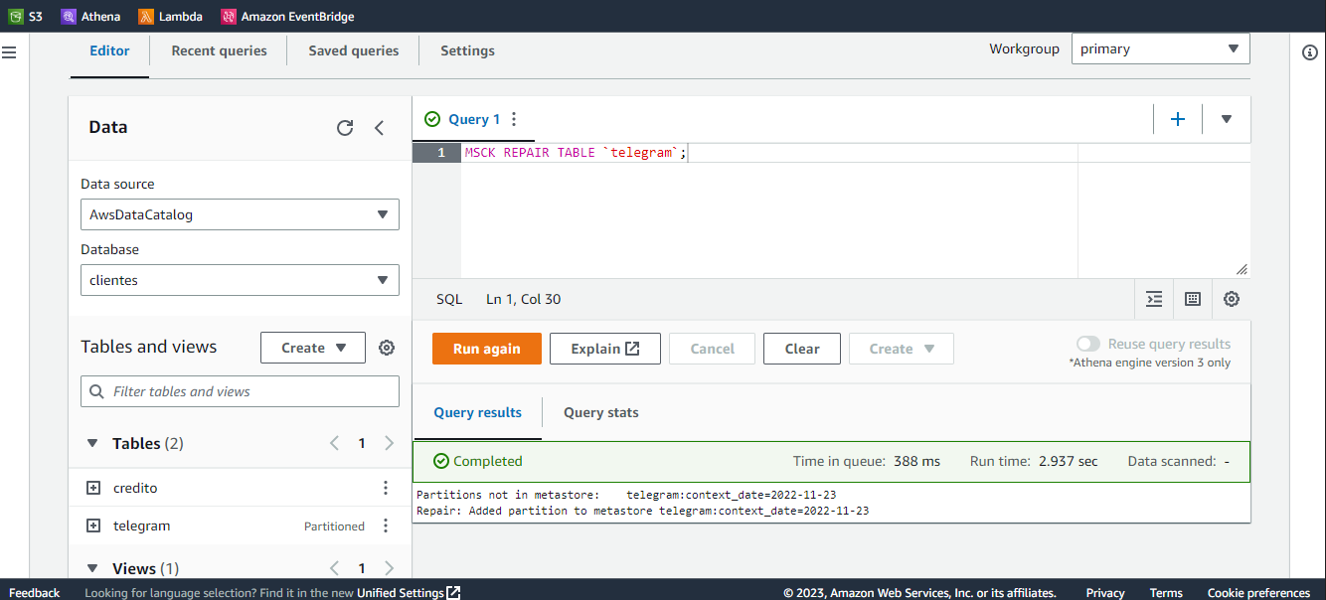

3.3. Execute as consultas SQL para explorar os dados.

```sql
--Quantidades de mensagens por dia
SELECT context_date, COUNT(*) AS messages
FROM telegram
GROUP BY context_date
ORDER BY 1 DESC;
```


|context_Date |  messages  |
|----------------|----------|
| 2022-11-23  | 6          |
| 2022-11-22  | 6          |


```sql
--Média do tamanho das mensagens.
SELECT
  context_date,
  CAST(AVG(length(text)) AS INT) AS mean_message_len
FROM telegram
GROUP BY  context_date
ORDER BY 1 DESC;
````

|context_Date |  messages |
|-------------|------------|
| 2022-11-23  | 18       |
| 2022-11-22  | 6         |

```sql
--Quantas mensagens tiveram erros de digitação?
SELECT count(*) AS messages_with_typos
FROM telegram
WHERE text LIKE '%*%';
```

|messages_with_typos |
|---|
| 4 |  

```sql
--Checagem:
SELECT user_first_name,
       text AS messages_with_typos,
       context_date
FROM telegram
WHERE text LIKE '%*%'
ORDER BY 3 DESC;
```

|user_first_name |  messages_with_typos  |  context_date|
|----------------|-----------------------|--------------|
| Fernanda       | Quente*               |  2022-11-23  |
| Fernanda       | Muito sol*            |  2022-11-23  |
| Fernanda       | Testando*             |  2022-11-22  |
| Fernanda       | Mensagem*             |  2022-11-22  |

## 4\. Storytelling

Siga as dicas da aula 4 para expor o seu projeto.

* **Contexto**

 O objetivo deste projecto foi implementar um pipeline dades para analisar mensagens em um grupo do telegram. O pipeline foi implementado utilizado serviços da Amzon Web Services (AWS).


* **Ferramentas utilizadas**

 ![Python](https://img.shields.io/badge/Python-black?style=flat-square&logo=python)
 ![Amazon AWS](https://img.shields.io/badge/AWS-black?style=flat-square&logo=amazon-aws)
![SQL](https://img.shields.io/badge/-SQL-black?style=flat-square&logo=sqlite)
![Telegram](https://img.shields.io/badge/-Telegram_Bots-blue?style=flat-square&logo=telegram)


     * O pipeline é ilustrado na célula seguinte

* **Conclusão**

Utilizando o serviço do AWS Athena e queries em SQL, é possível extrair insights acerca da mensagens enviadas diariamente via Telegram.

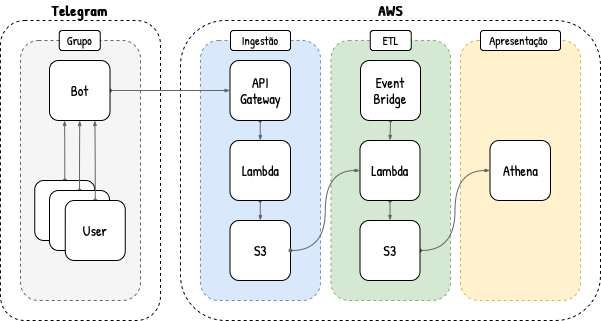